In [10]:
import random, math, statistics
from matplotlib import pyplot as plt

# Score-Based Model
スコアベースモデルとは、スコアを用いたランジュバン・モンテカルロが持つ問題点を解決するための、大きさの異なるノイズを用いた複数のスコア関数を学習する方法である。

## スコアを用いたランジュバン・モンテカルロの問題点

1. **低密度領域における推定スコア関数の不正確性**：被積分関数が$p(x)$に重み付けされているために、$p(x)$の小さい領域が$p(x)$の大きい領域に比べて相対的に無視されることに起因して、推定されるスコア関数が$p(x)$の小さな領域で不正確になる。
$$
\theta^{\text{ESM}} = \argmin_\theta \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 \right] = \frac{1}{2} \int_{\mathbb{R}^d} p(x) {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 dx
$$
2. **多峰性を持つ確率分布に対する学習の困難性**：MCMCを用いたサンプリングに共通する問題として、サンプルが直前に得られたサンプルに立脚して得られるため、データ分布が多峰性を持つ場合、ある峰から別の峰に移るために多くのステップを要する。例えばランジュバン・モンテカルロでは以下の更新則に従う。
$$
x_{k+1} = x_{k} + \alpha s(x_{k}) + \sqrt{2\alpha}u
$$

### Example 1. ランジュバン・モンテカルロの限界

以下のような多峰性を持つ分布を考える。

$$
\begin{align*}
p(x) &= \frac{\exp{\left( - {(x^2-1)}^2 \right)}}{Z} \\
s(x) &= -4x(x^2-1)
\end{align*}
$$

証明は省略するが、分配関数$Z$が有限であることがわかっている。
明らかに、この分布の平均は$0$となる（証明は被積分関数が奇関数であることに依る）。
また下のグラフから見ても明らかなように、この分布は多峰性を有する。

棄却サンプリングによってこの分布に対するサンプルを得て、このサンプルに対してデノイジングスコアマッチングを実行することを考える。

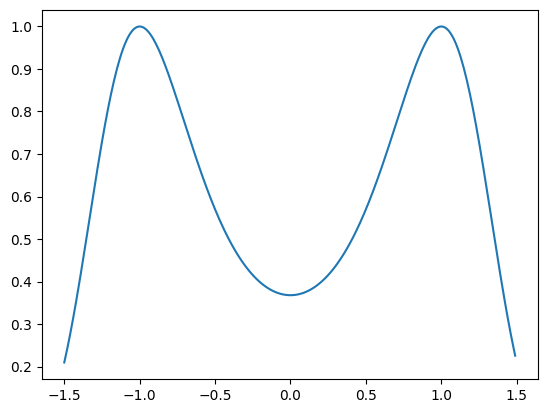

In [56]:
def objectiveDistribution(x):
    return math.exp(- (x**2 - 1)**2)

X = [i/100 for i in range(-150, 150)]
objective = [objectiveDistribution(x) for x in X]
plt.plot(X, objective)
plt.show()

$\alpha$、およびサンプル数を極端に小さく定めると、サンプルの平均が理論値の$0$から乖離し、$1$付近に留まってしまう。

In [58]:
nu = 10

def scoreFunction(x):
    return - 4 * x * (x**2 - 1)

K = 1000
burnin = 100
sample = list()
x = 1
alpha = 0.001
for k in range(K):
    u = random.gauss(0, 1)
    x = x + alpha * scoreFunction(x) + ((2 * alpha) ** 0.5) * u
    if k >= burnin:
        sample.append(x)

print(f"Target Average: 0.0000")
print(f"Sample Average: {statistics.mean(sample):.4f}")

Target Average: 0.0000
Sample Average: 1.1055


## 複数の異なるレベルのノイズによる多峰分布への適応

スコアベースモデルでは、大きさの異なる$T$個のスケール$\sigma_{\text{min}} = \sigma_1 < \sigma_2 < \cdots < \sigma_T = \sigma_{\text{max}}$を用意し、ノイズが付与されたデータの分布$p_{\sigma_t}(\tilde{x})$を考える。

$$
p_{\sigma_t}(\tilde{x}) = \int_{\mathbb{R}^d} p(x) \mathcal{N}(\tilde{x}; x, \sigma_t^2) dx
$$

デノイジングスコアマッチングと同様に、$p_{\sigma_t}(\tilde{x})$からのサンプルは、元データ$x$に対して$\mathcal{N}(0, \sigma_t^2)$からサンプリングされたノイズを付与することで得られる。

$$
\tilde{x} = x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_t^2)
$$

$\sigma_t$が非常に大きい場合、$\tilde{x}$中の$x$の影響が無視できるほど小さくなり、$\tilde{x}$は正規分布に従っているとみなせる。
逆に、$\sigma_t$が非常に小さい場合、$\tilde{x}$はほぼ$x$と等しく、元の分布の情報を残していると言える。
よって、まず大きな$\sigma_t$を用いた分布でランジュバン・モンテカルロを実行し、それにより得られた結果を初期値として使って、より小さい$\sigma_t$を用いた分布で再びランジュバン・モンテカルロを実行する。
これにより、元の分布に多峰性があったとしても、それらの峰を網羅することが期待される。
また、$p_{\sigma_t}(\tilde{x})$はノイズが付与された分布であるから、そのスコア関数はデノイジングスコアマッチングによって学習可能である。

まとめると、スコアベースモデルは以下のように実行される。
1. $x$の初期値を定める。
2. 大きさの異なる$T$個のスケール$\sigma_{\text{min}} = \sigma_1 < \sigma_2 < \cdots < \sigma_T = \sigma_{\text{max}}$、および$\alpha_1, \cdots, \alpha_T$を用意する。
3. $\mathcal{N}(0, \sigma_t^2)$からノイズ$\epsilon$をサンプリングし、ノイズ付きデータ$\tilde{x} = x + \epsilon$を生成することを考え、デノイジングスコアマッチングによって条件付き確率$p(\tilde{x}|x)$のスコア関数$s_{\sigma_t}(\tilde{x} | x)$を目標としたデノイジングスコアマッチングを行う。これによって得られたモデルを$s_{\theta}(\tilde{x}, \sigma_t)$とする。
4. $t = 1, \cdots, T$の各ステップにおいて、以下 Step 5,6 を行う。
5. $k = 1, \cdots, K$の各ステップにおいて、以下 Step 6 を行う。
6. $x \leftarrow x + \alpha_t s_\theta(x, \sigma_t) + \sqrt{2\alpha} u_k, \quad u_k \sim \mathcal{N}(0, 1)$
7. 最後の$x$を出力する。

### Example 2. サンプリング再チャレンジ

スコアベースモデルを用いて、先ほどの例で挙げた分布からのサンプリングを試みる。

まず、元データを棄却サンプリングを用いて生成する。

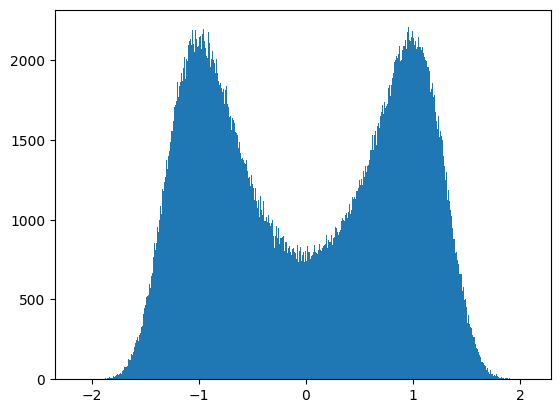

In [60]:
scale = 0.55
k = 2.8

def rejectionSampling(size, scale, k):
    def proposedDistribution(x, scale):
        return (1 / math.sqrt(2 * math.pi * scale**2)) * (math.exp(-((x-1)**2)/(2*scale**2)) + math.exp(-((x+1)**2)/(2*scale**2))) / 2
    def sampleFromProposedDistribution(scale):
        return random.gauss(-1 if random.random() < 0.5 else 1, scale)
    
    sample = list()
    while len(sample) < size:
        x = sampleFromProposedDistribution(scale)
        if random.random() < objectiveDistribution(x) / (k * proposedDistribution(x, scale)):
            sample.append(x)
    return sample

sample = rejectionSampling(1000000, scale, k)
plt.hist(sample, bins=1000)
plt.show()

次に、大きさの異なる$T$個のスケール$\sigma_t$によるノイズを考え、条件付き分布$p(\tilde{x}|x)$のスコア関数$s_{\sigma_t}(\tilde{x} | x)$を目標としたデノイジングスコアマッチングを行う。

提案分布は目標と同じ形状とする。

$$
\begin{align*}
\hat{p}_\theta (x) &= \frac{\exp{\left( - {({(ax)}^2-b)}^2 \right)}}{Z} \\
\hat{s}_\theta (x) &= -4a^2x({(ax)}^2 - b)
\end{align*}
$$

$$
\begin{align*}
a^{\text{DSM}}, b^{\text{DSM}} &= \argmin_{a, b} \frac{1}{2} \mathbb{E}_{x \sim p(x), \epsilon \sim \mathcal{N}(0, \sigma_t^2)} \left[ {\left|\left| \hat{s}_\theta(x + \epsilon) + \frac{1}{\sigma_t^2} \epsilon \right|\right|}^2 \right] \\
\end{align*}
$$